![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 4 - Deep Learning Basics</center>
### <center> Optimization Methods (SGDM & Adam)</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/04_OptimizationMethods/MainOptimization1.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

np.random.seed(1)

For Colab users:

In [4]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/DeepLearningMethods/04_OptimizationMethods/OptimizationExampleAux.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
#-- What we have so far:
from OptimizationExampleAux import LinearLayer, ReLULayer, SequentialModel, CrossEntropyLoss, Dataset, Accuracy, Plot, Recorder

### Get Fashion MNIST dataset

In [6]:
import torchvision
import torchvision.transforms as transforms

#-- For now, we use PyTorch just to get the data:
oTorchTrainSet = torchvision.datasets.FashionMNIST(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
# oTorchTestSet  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

lClasses = oTorchTrainSet.classes
mX       = oTorchTrainSet.data.view(-1,784).numpy() / 255
vY       = oTorchTrainSet.targets.numpy()
mX.shape, vY.shape, lClasses

((60000, 784),
 (60000,),
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

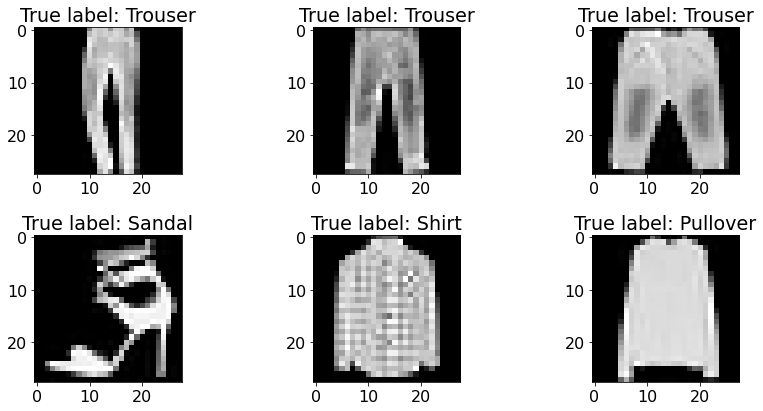

In [7]:
#-- Plot a few examples:
N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(12,6))
for ax in fig.axes:
    idx = np.random.randint(0, N)
    ax.imshow(np.reshape(mX[idx,:], (28, 28)), cmap='gray')
    ax.set_title('True label: ' + str(lClasses[vY[idx]]))
    
plt.tight_layout()
plt.show()

###  Normalize data:

In [8]:
vMean = np.mean(mX, axis=0)
vStd  = np.std(mX, axis=0)
mX    = (mX - vMean) / vStd

###  Split to train and validation:

In [9]:
from sklearn.model_selection import train_test_split

Ntrain = 55000
Nval   = 5000
mTrainX, mValX, vTrainY, vValY = train_test_split(mX, vY, train_size=Ntrain, test_size=Nval)

(mTrainX.shape, 
vTrainY.shape, 
mValX.shape,  
vValY.shape)

((55000, 784), (55000,), (5000, 784), (5000,))

### A basic optimizer (only SGD):
$$\boldsymbol{p}^{\left(t+1\right)}=\boldsymbol{p}^{\left(t\right)}-\mu\nabla_{\boldsymbol{p}}L$$

In [10]:
#-- Basic gradient descent update rule:
class Sgd:
    def __init__(self, lr=1e-3):
        self.lr = lr
        
    def Step(self, mP, mDp, dState={}):
        mP -= self.lr * mDp
        return mP, dState

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
class Optimizer:
    def __init__(self, oUpdateRule):
        self.oUpdateRule = oUpdateRule #-- SGD, SGDM, ADAM
        self.dStates     = {}
            
    def Step(self, oModel, lr=None):
        if lr is not None:
            self.oUpdateRule.lr = lr
        
        for ii, oLayer in enumerate(oModel.lLayers):
            for sParamKey in oLayer.dGrads:
                #-- Get param, gradient and history:
                mW          = oLayer.dParams[sParamKey]
                mDw         = oLayer.dGrads[sParamKey]
                sLayerParam = str(ii) + sParamKey
                dState      = self.dStates.get(sLayerParam, {})
                
                #-- Apply step:
                mW, dState  = self.oUpdateRule.Step(mW, mDw, dState)
                
                #-- Set param and hisoty:
                oLayer.dParams[sParamKey] = mW
                self.dStates[sLayerParam] = dState

### Define the training loop with optimizer:

In [11]:
import time
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def TrainLoop(oModel, oTrainData, oOptim):
    
    epochLoss = 0
    epochAcc  = 0
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainData):
        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters
        oOptim.Step(oModel)
            
        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)
        print(f'\rIteration: {ii:3d}: loss = {loss:.6f}', end='')
    
    print('', end='\r')
    epochLoss /= ii + 1
    epochAcc  /= ii + 1
    
    return epochLoss, epochAcc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def ValidationLoop(oModel, oValData):
    
    epochLoss = 0
    epochAcc  = 0
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oValData):
        #-- Forward:
        mZ      = oModel.Forward(mX)
        loss, _ = CrossEntropyLoss(vY, mZ)
               
        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)
    
    epochLoss /= ii + 1
    epochAcc  /= ii + 1
    
    return epochLoss, epochAcc

In [12]:
def TrainModel(oModel, oTrainData, oValData, numEpochs, oOptim):
   
    oRecorder = Recorder([
        Plot('Loss',       'train', 'epoch', 'b'),
        Plot('Loss',       'val',   'epoch', 'r'),
        Plot('Accuracy',   'train', 'epoch', 'b'),
        Plot('Accuracy',   'val',   'epoch', 'r'),
    ])

    for epoch in range(numEpochs):
        startTime           = time.time()
        #-- Train:
        trainLoss, trainAcc = TrainLoop(oModel, oTrainData, oOptim)
        #-- Validation:
        valLoss,   valAcc   = ValidationLoop(oModel, oValData)
        endTime             = time.time()

        #-- Display:
        oRecorder.Append('Loss',     'train', trainLoss),
        oRecorder.Append('Loss',     'val',   valLoss),
        oRecorder.Append('Accuracy', 'train', trainAcc),
        oRecorder.Append('Accuracy', 'val',   valAcc),
        oRecorder.Draw()
        
        print('Epoch '              f'{epoch:3d}:',     end='')
        print(' | Train loss: '     f'{trainLoss:.5f}', end='')
        print(' | Val loss: '       f'{valLoss:.5f}',   end='')
        print(' | Train Accuracy: ' f'{trainAcc:2.4f}', end='')
        print(' | Val Accuracy: '   f'{valAcc:2.4f}',   end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |')
        

###  Learning rate sweep (with an optimizer):

In [13]:
def LearningRateSweep(oModel, oTrainData, oOptim, vLearningRate):
   
    #-- Record mini-batches loss:
    oRecorder = Recorder([
        Plot('Batch loss', 'train', 'learning rate', 'b'),
    ])

    numIter = len(vLearningRate)
    ii      = 0
    while ii < numIter:
        #-- Iterate over the mini-batches:
        for mX, vY in oTrainData:
            if ii >= numIter:
                break
                
            #-- Forward:
            mZ        = oModel.Forward(mX)
            loss, mDz = CrossEntropyLoss(vY, mZ)

            #-- Backward:
            oModel.Backward(mDz)

            #-- Update parameters (with new learning rate)
            oOptim.Step(oModel, vLearningRate[ii])

            oRecorder.Append('Batch loss', 'train', loss)
            oRecorder.Draw()        
        
            ii += 1
            
    #-- Display:
    ax = oRecorder.dAxes['Batch loss']
    ax.lines[0].set_xdata(vLearningRate)
    ax.axis(xmin=vLearningRate[0], xmax=vLearningRate[-1])
    ax.set_xscale('log')
    oRecorder.Draw()
    
    return oRecorder

###  Define a model:

In [14]:
def GetModel():
    oModel = SequentialModel([
        LinearLayer(784, 500),
        ReLULayer(),
        LinearLayer(500, 250),
        ReLULayer(),
        LinearLayer(250, 150),
        ReLULayer(),
        LinearLayer(150, 100),
        ReLULayer(),
        LinearLayer(100,  10),
    ])
    
    return oModel

###  Search for a learning rate:

In [15]:
batchSize     = 1024
oTrainSet     = Dataset(mTrainX.T, vTrainY, batchSize)
oValSet       = Dataset(mValX.T,   vValY,  batchSize)

<IPython.core.display.Javascript object>


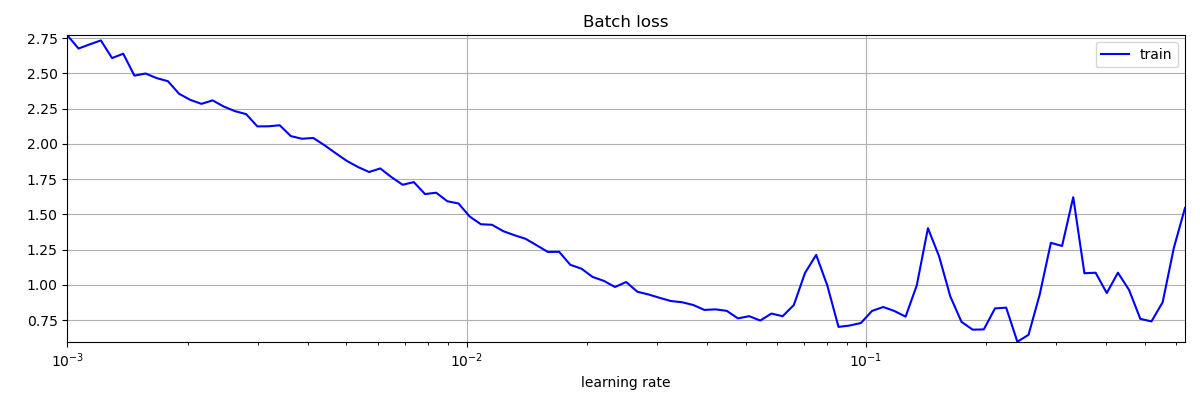

In [16]:
%matplotlib notebook
#-- Colab users should use `inline`
# %matplotlib inline

oModel        = GetModel()
vLearningRate = np.logspace(-3, -0.2, 101)
oOptim        = Optimizer(Sgd())
oRecorder     = LearningRateSweep(oModel, oTrainSet, oOptim, vLearningRate)

For Colab users:

<IPython.core.display.Javascript object>


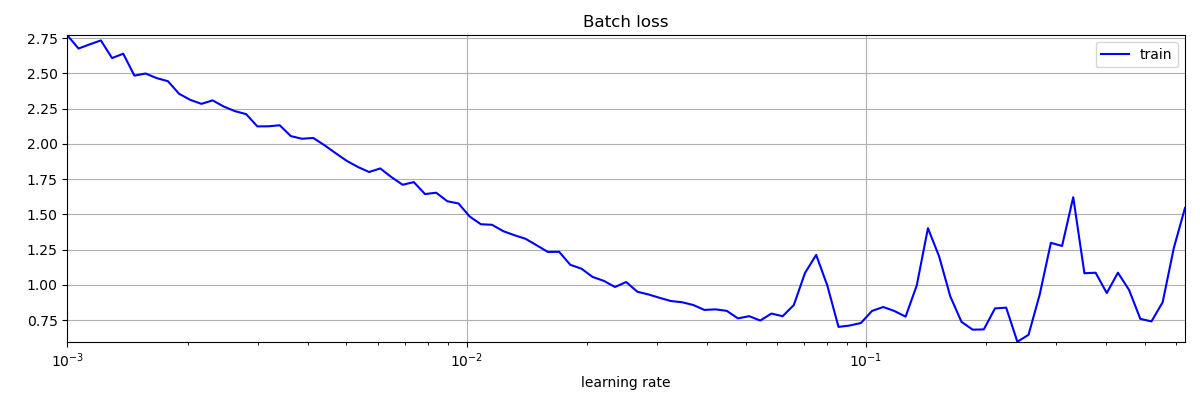

In [17]:
%matplotlib inline
oRecorder.fig

<IPython.core.display.Javascript object>


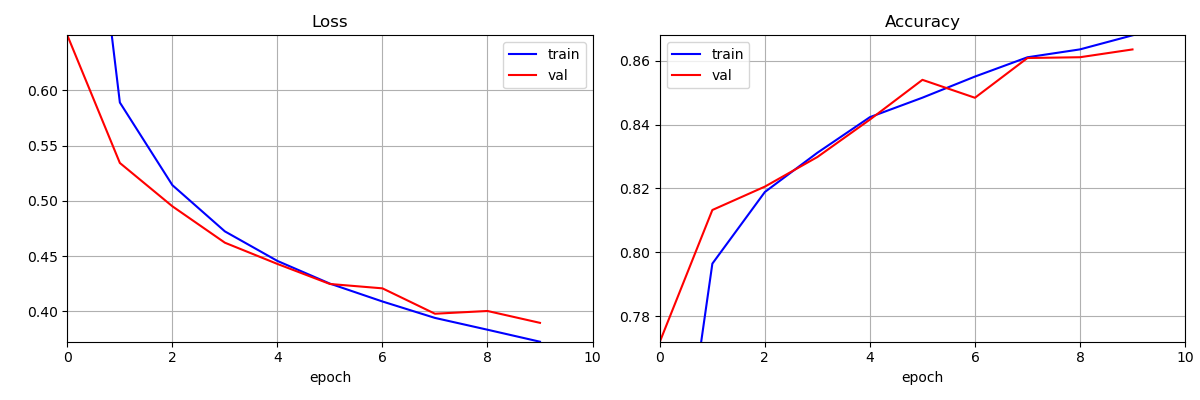

Epoch   0: | Train loss: 0.98304 | Val loss: 0.64968 | Train Accuracy: 0.6814 | Val Accuracy: 0.7720 | epoch time: 4.201 |
Epoch   1: | Train loss: 0.58895 | Val loss: 0.53429 | Train Accuracy: 0.7964 | Val Accuracy: 0.8132 | epoch time: 4.181 |
Epoch   2: | Train loss: 0.51424 | Val loss: 0.49511 | Train Accuracy: 0.8189 | Val Accuracy: 0.8206 | epoch time: 4.032 |
Epoch   3: | Train loss: 0.47243 | Val loss: 0.46220 | Train Accuracy: 0.8312 | Val Accuracy: 0.8298 | epoch time: 4.021 |
Epoch   4: | Train loss: 0.44572 | Val loss: 0.44300 | Train Accuracy: 0.8423 | Val Accuracy: 0.8416 | epoch time: 4.070 |
Epoch   5: | Train loss: 0.42521 | Val loss: 0.42487 | Train Accuracy: 0.8484 | Val Accuracy: 0.8540 | epoch time: 3.947 |
Epoch   6: | Train loss: 0.40905 | Val loss: 0.42093 | Train Accuracy: 0.8550 | Val Accuracy: 0.8484 | epoch time: 4.030 |
Epoch   7: | Train loss: 0.39420 | Val loss: 0.39798 | Train Accuracy: 0.8611 | Val Accuracy: 0.8608 | epoch time: 4.057 |
Epoch   8: | Tra

In [18]:
%matplotlib notebook

oModel = GetModel()
oOptim = Optimizer(Sgd(lr=2e-2))
TrainModel(oModel, oTrainSet, oValSet, 10, oOptim)

### SGDM and Adam implementations
#### SGDM:
$$\boldsymbol{v}^{\left(t\right)}=\beta\boldsymbol{v}^{\left(t-1\right)}-\mu\nabla f\left(\boldsymbol{p}^{\left(t\right)}\right)$$
$$\boldsymbol{p}^{\left(t+1\right)}=\boldsymbol{p}^{\left(t\right)}+\boldsymbol{v}^{\left(t\right)}$$

#### Adam:
$$\boldsymbol{g}=\nabla f\left(\boldsymbol{p}^{\left(t\right)}\right)$$
$$\boldsymbol{v}^{\left(t\right)}=\beta_{1}\boldsymbol{v}^{\left(t-1\right)}+\left(1-\beta_{1}\right)\boldsymbol{g}$$
$$\boldsymbol{s}^{\left(t\right)}=\beta_{2}\boldsymbol{s}^{\left(t-1\right)}+\left(1-\beta_{2}\right)\left(\boldsymbol{g}\odot\boldsymbol{g}\right)$$
$$\tilde{\boldsymbol{v}}^{\left(t\right)}=\frac{1}{\left(1-\beta_{1}^{t}\right)}\boldsymbol{v}^{\left(t\right)}$$
$$\tilde{\boldsymbol{s}}^{\left(t\right)}=\frac{1}{\left(1-\beta_{2}^{t}\right)}\boldsymbol{s}^{\left(t\right)}$$
$$\boldsymbol{p}^{\left(t+1\right)}=\boldsymbol{p}^{\left(t\right)}-\mu\tilde{\boldsymbol{v}}^{\left(t\right)}\oslash\left(\sqrt{\tilde{\boldsymbol{s}}^{\left(t\right)}}+\epsilon\right)$$

In [19]:
class Sgdm:
    def __init__(self, lr=1e-3, beta=0.9):
        self.lr   = lr
        self.beta = beta
        
    def Step(self, mP, mDp, dState={}):
        mV            = dState.get('mV', np.zeros(mP.shape))
        mV            = self.beta * mV - self.lr * mDp
        mP           += mV
        dState['mV']  = mV
        
        return mP, dState
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#    
class Adam:
    def __init__(self, lr=1e-3, beta1=0.9, beta2=0.99, eps=1e-8):
        self.lr    = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps   = eps
        
    def Step(self, mP, mDp, dState={}):
        mV            = dState.get('mV', np.zeros(mP.shape))
        mS            = dState.get('mS', np.zeros(mP.shape))
        ii            = dState.get('ii', 0) + 1
        
        mV            = self.beta1 * mV + (1 - self.beta1) * mDp
        mS            = self.beta2 * mS + (1 - self.beta2) * mDp * mDp
        
        mTildeV       = mV / (1 - self.beta1**ii)
        mTildeS       = mS / (1 - self.beta2**ii)
        
        mP           -= self.lr * mTildeV / (np.sqrt(mTildeS) + self.eps)
        dState['mV']  = mV
        dState['mS']  = mS
        dState['ii']  = ii
        
        return mP, dState

### Train the same architecture with SGDM:

<IPython.core.display.Javascript object>


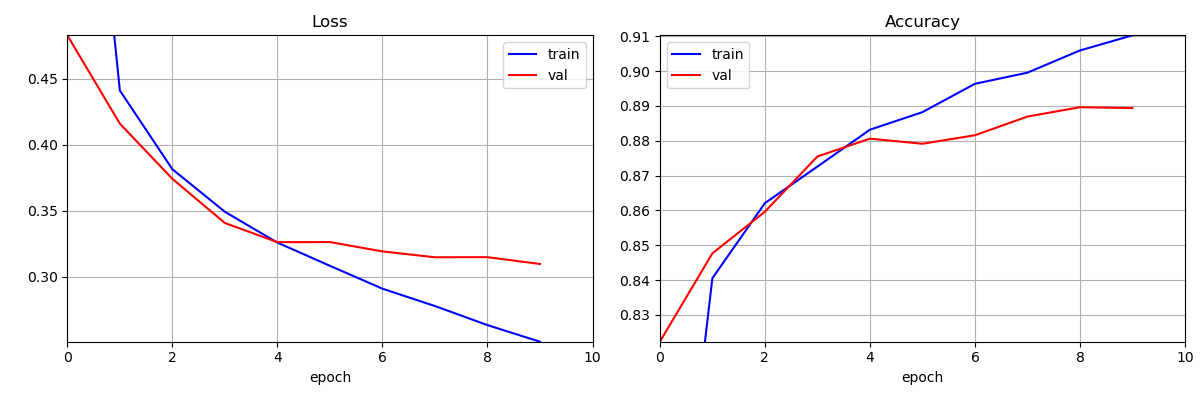

Epoch   0: | Train loss: 0.83022 | Val loss: 0.48297 | Train Accuracy: 0.7112 | Val Accuracy: 0.8223 | epoch time: 4.243 |
Epoch   1: | Train loss: 0.44113 | Val loss: 0.41597 | Train Accuracy: 0.8405 | Val Accuracy: 0.8477 | epoch time: 4.222 |
Epoch   2: | Train loss: 0.38139 | Val loss: 0.37411 | Train Accuracy: 0.8621 | Val Accuracy: 0.8596 | epoch time: 4.168 |
Epoch   3: | Train loss: 0.34911 | Val loss: 0.34060 | Train Accuracy: 0.8726 | Val Accuracy: 0.8755 | epoch time: 4.144 |
Epoch   4: | Train loss: 0.32573 | Val loss: 0.32607 | Train Accuracy: 0.8832 | Val Accuracy: 0.8806 | epoch time: 4.098 |
Epoch   5: | Train loss: 0.30814 | Val loss: 0.32614 | Train Accuracy: 0.8882 | Val Accuracy: 0.8792 | epoch time: 4.351 |
Epoch   6: | Train loss: 0.29079 | Val loss: 0.31906 | Train Accuracy: 0.8964 | Val Accuracy: 0.8816 | epoch time: 4.285 |
Epoch   7: | Train loss: 0.27762 | Val loss: 0.31461 | Train Accuracy: 0.8996 | Val Accuracy: 0.8870 | epoch time: 4.244 |
Epoch   8: | Tra

In [20]:
%matplotlib notebook

oModel = GetModel()
oOptim = Optimizer(Sgdm(lr=1e-2, beta=0.9))
TrainModel(oModel, oTrainSet, oValSet, 10, oOptim)

#### Question:
Which optimizer obtains a better performance after 10 iterations?

### Let us try Adam:

<IPython.core.display.Javascript object>


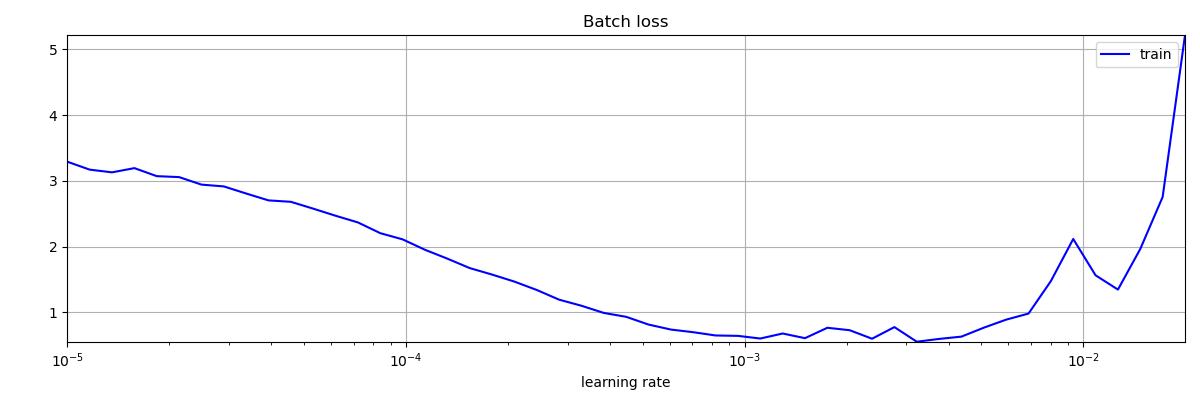

In [21]:
%matplotlib notebook
#-- Colab users should use `inline`
# %matplotlib inline

oModel        = GetModel()
oOptim        = Optimizer(Adam(lr=0, beta1=0.7, beta2=0.8))
vLearningRate = np.logspace(-5, -1.7, 51)
oRecorder     = LearningRateSweep(oModel, oTrainSet, oOptim, vLearningRate)

For Colab users:

<IPython.core.display.Javascript object>


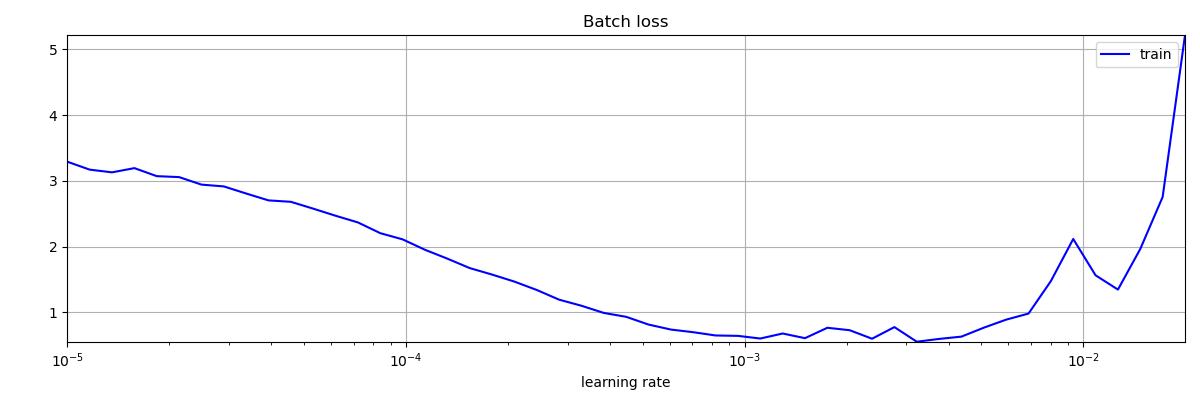

In [22]:
%matplotlib inline
oRecorder.fig

<IPython.core.display.Javascript object>


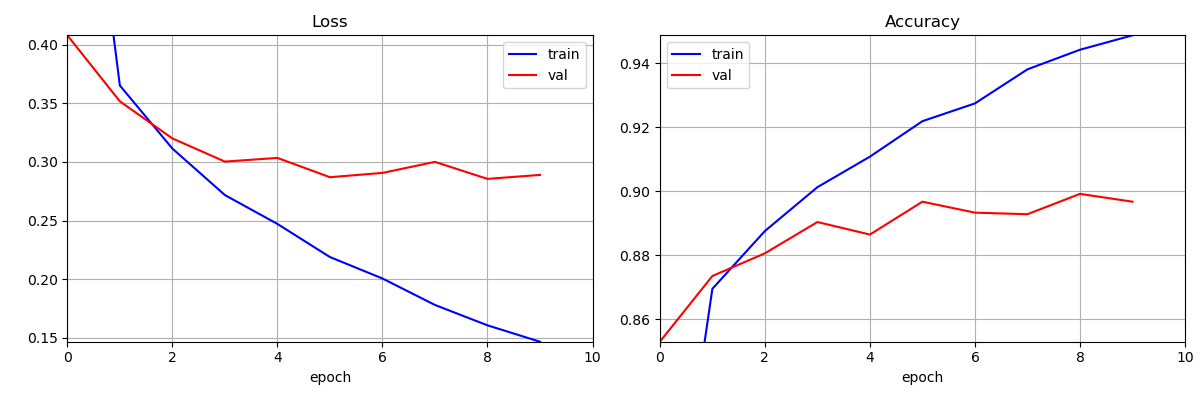

Epoch   0: | Train loss: 0.71714 | Val loss: 0.40794 | Train Accuracy: 0.7572 | Val Accuracy: 0.8530 | epoch time: 5.439 |
Epoch   1: | Train loss: 0.36518 | Val loss: 0.35167 | Train Accuracy: 0.8695 | Val Accuracy: 0.8735 | epoch time: 5.359 |
Epoch   2: | Train loss: 0.31143 | Val loss: 0.32007 | Train Accuracy: 0.8876 | Val Accuracy: 0.8806 | epoch time: 5.577 |
Epoch   3: | Train loss: 0.27179 | Val loss: 0.30032 | Train Accuracy: 0.9013 | Val Accuracy: 0.8904 | epoch time: 5.607 |
Epoch   4: | Train loss: 0.24719 | Val loss: 0.30346 | Train Accuracy: 0.9108 | Val Accuracy: 0.8865 | epoch time: 6.052 |
Epoch   5: | Train loss: 0.21897 | Val loss: 0.28701 | Train Accuracy: 0.9219 | Val Accuracy: 0.8967 | epoch time: 5.878 |
Epoch   6: | Train loss: 0.20069 | Val loss: 0.29068 | Train Accuracy: 0.9274 | Val Accuracy: 0.8933 | epoch time: 6.306 |
Epoch   7: | Train loss: 0.17813 | Val loss: 0.30008 | Train Accuracy: 0.9380 | Val Accuracy: 0.8928 | epoch time: 5.564 |
Epoch   8: | Tra

In [23]:
%matplotlib notebook

oModel = GetModel()
oOptim = Optimizer(Adam(lr=5e-4, beta1=0.9, beta2=0.99))
TrainModel(oModel, oTrainSet, oValSet, 10, oOptim)

### Training too much will overfit the training data:

<IPython.core.display.Javascript object>


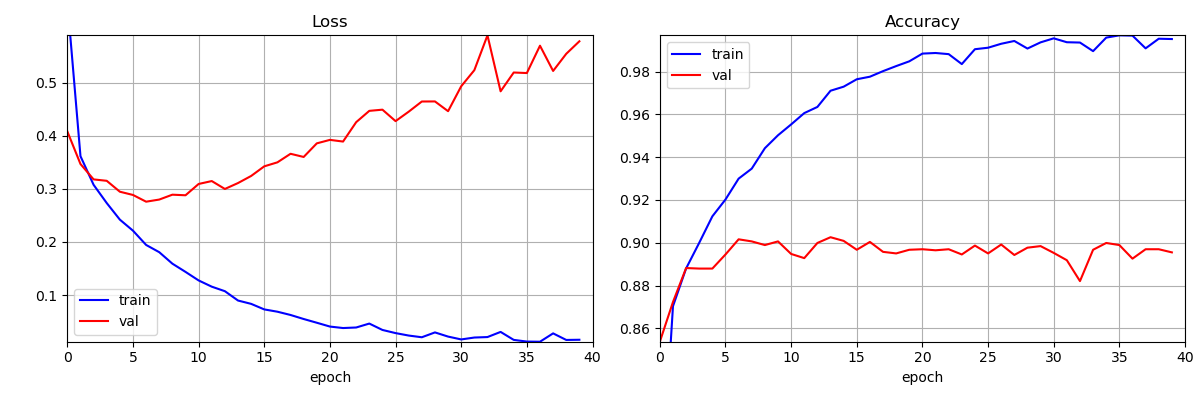

Epoch   0: | Train loss: 0.65315 | Val loss: 0.40822 | Train Accuracy: 0.7716 | Val Accuracy: 0.8538 | epoch time: 5.442 |
Epoch   1: | Train loss: 0.36160 | Val loss: 0.34687 | Train Accuracy: 0.8704 | Val Accuracy: 0.8723 | epoch time: 5.683 |
Epoch   2: | Train loss: 0.30766 | Val loss: 0.31788 | Train Accuracy: 0.8880 | Val Accuracy: 0.8882 | epoch time: 5.812 |
Epoch   3: | Train loss: 0.27334 | Val loss: 0.31522 | Train Accuracy: 0.9000 | Val Accuracy: 0.8879 | epoch time: 5.752 |
Epoch   4: | Train loss: 0.24210 | Val loss: 0.29469 | Train Accuracy: 0.9123 | Val Accuracy: 0.8879 | epoch time: 5.859 |
Epoch   5: | Train loss: 0.22129 | Val loss: 0.28857 | Train Accuracy: 0.9202 | Val Accuracy: 0.8945 | epoch time: 5.498 |
Epoch   6: | Train loss: 0.19444 | Val loss: 0.27591 | Train Accuracy: 0.9300 | Val Accuracy: 0.9016 | epoch time: 5.713 |
Epoch   7: | Train loss: 0.18079 | Val loss: 0.27992 | Train Accuracy: 0.9346 | Val Accuracy: 0.9006 | epoch time: 6.213 |
Epoch   8: | Tra

In [24]:
%matplotlib notebook

oModel = GetModel()
oOptim = Optimizer(Adam(lr=5e-4, beta1=0.9, beta2=0.99))
TrainModel(oModel, oTrainSet, oValSet, 40, oOptim)